In [62]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
import pandas as pd
df = pd.read_excel('Colormap.xlsx')

In [63]:
global NumSpecies,mu,lambdaa,gamma,D,eta,kappa

In [64]:
def GetPositive(input):
    temp=[]
    for i in input:
        if i>0:
            temp.append(i)
    return temp

In [65]:
def MultiSpecies(t,y):
    global NumSpecies,mu,gamma,D
    dydt=np.zeros(NumSpecies)
    for i in range(NumSpecies):
            sumy=0
            for j in range(NumSpecies):
                sumy=sumy+y[j]
            dydt[i]=mu[i]*y[i]*(1-(gamma*sumy-gamma*y[i]+y[i]))-D*y[i]
    return dydt

In [66]:
def MultiSpeciesHGT(t,y):
    global NumSpecies,mu,lambdaa,gamma,D,eta,kappa
    dydt=np.zeros(NumSpecies*(1+NumSpecies))
    for i in range(NumSpecies):
        ss=1
        sumy=0
        for j in range(NumSpecies):
            if i!=j:
                ss=ss*(1+lambdaa[j]*y[NumSpecies+i*NumSpecies+j]/y[i])
            sumy=sumy+y[j]
        dydt[i]=mu[i]*y[i]*ss*(1-(gamma*sumy-gamma*y[i]+y[i]))-D*y[i]
        for j in range(NumSpecies):
                if j==i:
                    dydt[NumSpecies+i*NumSpecies+j]=dydt[i]
                else:
                    ss=1
                    for k in range(NumSpecies):
                        if k!=i and k!=j:
                            ss=ss*(1+lambdaa[k]*y[NumSpecies+i*NumSpecies+k]/y[i])
                    donor=0
                    for k in range(NumSpecies):
                        donor=donor+y[NumSpecies+k*NumSpecies+j]
                    dydt[NumSpecies+i*NumSpecies+j]=mu[i]*y[NumSpecies+i*NumSpecies+j]*ss*(1+lambdaa[j])*(1-(gamma*sumy-gamma*y[i]+y[i]))+eta*(y[i]-y[NumSpecies+i*NumSpecies+j])*donor-(kappa+D)*y[NumSpecies+i*NumSpecies+j]
    return dydt

In [67]:
NumSpecies=20
mu0=0.5
mu=mu0*np.ones(NumSpecies)
D=0.2
gamma=0.9
eta=0.3
kappa=0.005
initialHGT=np.zeros(NumSpecies**2+NumSpecies)
for i in range(NumSpecies):
    initialHGT[i]=1/NumSpecies
    initialHGT[NumSpecies+i*NumSpecies+i]=initialHGT[i]
    
initial=np.zeros(NumSpecies)
for i in range(NumSpecies):
    initial[i]=1/NumSpecies
    
cycles=30
durations=15+15*np.random.rand(cycles)
time=[]
Abund=[]
AbundHGT=[]
for i in range(cycles):
    mu=np.multiply(mu,(0.95+0.1*np.random.rand(NumSpecies)))
    lambdaa=np.divide(mu,mu0)-1
    timespan=np.arange(0,durations[i],0.1)
    if i==0:
        time=timespan
    else:
        time=np.concatenate((time,np.add(timespan,max(time))))
    sol=solve_ivp(MultiSpecies,[0,max(timespan)],initial,method='RK45',t_eval = timespan)
    y1=sol.y
    if i==0:
        Abund=y1[range(NumSpecies),:]
    else:
        Abund=np.concatenate((Abund,y1[range(NumSpecies),:]),axis=1)

    initial=y1[range(NumSpecies),-1]

    sol=solve_ivp(MultiSpeciesHGT,[0,max(timespan)],initialHGT,method='RK45',t_eval = timespan)
    y2=sol.y
    if i==0:
        AbundHGT=y2[range(NumSpecies),:]
    else:
        AbundHGT=np.concatenate((AbundHGT,y2[range(NumSpecies),:]),axis=1)  
    initialHGT=y2[range(NumSpecies**2+NumSpecies),-1]


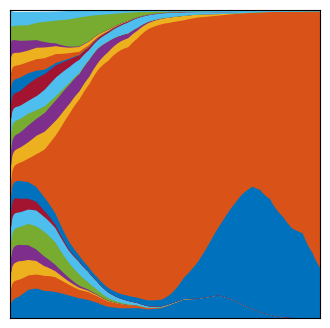

In [72]:
RelAbund=Abund
for i in range(np.size(Abund,0)):
    for j in range(np.size(Abund,1)):
        RelAbund[i,j]=Abund[i,j]/np.sum(Abund[:,j])
plt.figure(figsize=(4,4))
for i in range(NumSpecies):
    if i==0:
        plt.fill_between(time,0,RelAbund[i,:],color=(df.a[i],df.b[i],df.c[i]))
    else:
        plt.fill_between(time,np.sum(RelAbund[range(i),:],0),np.sum(RelAbund[range(i+1),:],0),color=(df.a[i],df.b[i],df.c[i]))  
plt.xlim(0,max(time))
plt.ylim(0,1)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
plt.savefig('Examples_1.pdf')
plt.show()

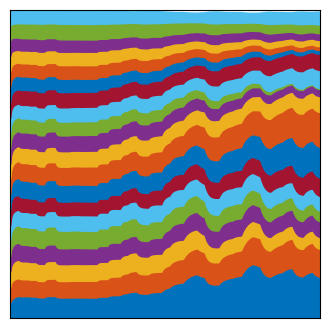

In [76]:
RelAbundHGT=AbundHGT
for i in range(np.size(AbundHGT,0)):
    for j in range(np.size(AbundHGT,1)):
        RelAbundHGT[i,j]=AbundHGT[i,j]/np.sum(AbundHGT[:,j])
plt.figure(figsize=(4,4))
for i in range(NumSpecies):
    if i==0:
        plt.fill_between(time,0,RelAbundHGT[i,:],color=(df.a[i],df.b[i],df.c[i]))
    else:
        plt.fill_between(time,np.sum(RelAbundHGT[range(i),:],0),np.sum(RelAbundHGT[range(i+1),:],0),color=(df.a[i],df.b[i],df.c[i]))  
plt.xlim(0,max(time))
plt.ylim(0,1)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
plt.savefig('Examples_2.pdf')
plt.show()